In [1]:
from collections import Counter
import glob
from lifelines import KaplanMeierFitter
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import researchpy as rp
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
EVEROLIMUS = "C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)OCCO)C)/C)O)OC)C)C)/C)OC"
RIBOCICLIB = "CN(C)C(=O)C1=CC2=CN=C(N=C2N1C3CCCC3)NC4=NC=C(C=C4)N5CCNCC5"
PALBOCICLIB = "CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C"
CAPIVASERTIB = "C1CN(CCC1(C(=O)N[C@@H](CCO)C2=CC=C(C=C2)Cl)N)C3=NC=NC4=C3C=CN4"
FULVESTRANT = "C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2O)[C@@H](CC4=C3C=CC(=C4)O)CCCCCCCCCS(=O)CCCC(C(F)(F)F)(F)F"

drug_func_map = {RIBOCICLIB:'CDK4_6_Inhibitor_Overall', EVEROLIMUS:'mTOR_Inhibitor_Overall'}
drug_func_map[PALBOCICLIB] = 'CDK4_6_Inhibitor_Overall'
drug_func_map[CAPIVASERTIB] = 'AKT_Inhibitor_Overall'

drug_name_map = {EVEROLIMUS:'Everolimus', RIBOCICLIB:'Ribociclib', PALBOCICLIB:'Palbociclib'}
drug_name_map[CAPIVASERTIB] = 'Capivasertib'
drug_name_map[FULVESTRANT] = 'Fulvestrant'

In [4]:
def generate_test_data(genie_data, drugs):
    
    cell_lines = sorted(genie_data['Sample_ID'])
    cell_line_df = pd.DataFrame(cell_lines, columns=['C'])
    
    test_data = []
    for d in drugs:
        for c in cell_lines:
            test_data.append((c, d, 0.5))
    test_data_df = pd.DataFrame(test_data, columns=['C', 'D', 'AUC'])
    
    return cell_line_df, test_data_df

In [5]:
def generate_cell_mutation_file(all_genie_genes, other_genes, genie_data, all_mutation_data):
    
    cell_lines = sorted(genie_data['Sample_ID'])

    filtered_mut_data = all_mutation_data.query('sampleId in @cell_lines')
    filtered_mut_data = filtered_mut_data.sort_values(by=['sampleId'])
    filtered_mut_data.drop(columns=['sampleId', 'Altered'], inplace=True)
    
    non_overlapping_genes_AnotB = [g for g in all_genie_genes if g not in other_genes] #A-B
    
    filtered_mut_data.drop(columns=non_overlapping_genes_AnotB, inplace=True)
    
    non_overlapping_genes_BnotA = [g for g in other_genes if g not in all_genie_genes] #B-A
    
    for gene in non_overlapping_genes_BnotA:
        filtered_mut_data[gene] = 0
        
    filtered_mut_data.sort_index(inplace=True, axis=1)
    
    return filtered_mut_data

In [6]:
def create_confusion_matrix(table, entity):
    
    fig, ax = plt.subplots(figsize=(7,6))    
    sns.heatmap(table, vmin=0, vmax=60, annot=True, cmap='Blues', ax=ax)
    ax.invert_yaxis()
    ax.invert_xaxis()
    plt.yticks(rotation=0)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_ylabel(entity + ' True')
    ax.set_xlabel(entity + ' Prediction')

In [7]:
def create_kaplan_meier(true_positive, false_negative, false_positive, true_negative, entity):
    
    if len(true_positive) == 0 or len(true_negative) == 0 or len(false_positive) == 0 or len(false_negative) == 0:
        return
        
    kmf_d = KaplanMeierFitter(label=entity + " Survival plot")
    
    kmf_d.fit(true_positive, label='True Sensitive(TP)')
    a = kmf_d.plot(ci_show=False)
    
    kmf_d.fit(false_negative, label='False Resistive(FN)')
    a = kmf_d.plot(ci_show=False)
    
    kmf_d.fit(false_positive, label='False Sensitive(FP)')
    a = kmf_d.plot(ci_show=False)
    
    kmf_d.fit(true_negative, label='True Resistive(TN)')
    a = kmf_d.plot(ci_show=False)
    
    a.set_xlim(0, 120)
    a.set_xlabel('Overall_Survival_Months')
    a.set_ylabel('Surviving Fractions')

In [8]:
def create_drug_combo_survival_plot(genie_data, pred_df, pred_median_dict, d_list):
    
    pos_ctrl_df = genie_data.query('CDK4_6_Inhibitor_Overall == "Yes" or mTOR_Inhibitor_Overall == "Yes"')
    pos_ctrl_df = pos_ctrl_df.sort_values(by=['Sample_ID'])
    
    neg_ctrl_df = genie_data.query('CDK4_6_Inhibitor_Overall == "No" and mTOR_Inhibitor_Overall == "No"')
    neg_ctrl_df = neg_ctrl_df.sort_values(by=['Sample_ID'])
    
    true_positive = []
    false_negative = []
    false_positive = []
    true_negative = []
    
    for _,row in pos_ctrl_df.iterrows():
        
        sampleId = row['Sample_ID']
        df = pred_df.query('C == @sampleId')
        dp_map = dict(zip(df.D, df.P_AUC))
        
        is_positive = False
        for d in d_list:
            if row[drug_func_map[d]] == 'Yes' and dp_map[d] <= pred_median_dict[d]:
                is_positive = True
        
        if is_positive:
            true_positive.append(row['Overall_Survival_Months'])
        else:
            false_negative.append(row['Overall_Survival_Months'])
        
    print('True Sensitive:', len(true_positive))
    print('False Resistive:', len(false_negative))
    
    for _,row in neg_ctrl_df.iterrows():
        
        sampleId = row['Sample_ID']
        df = pred_df.query('C == @sampleId')
        dp_map = dict(zip(df.D, df.P_AUC))
        
        is_positive = False
        for d in d_list:
            if dp_map[d] <= pred_median_dict[d]:
                is_positive = True
        
        if is_positive:
            false_positive.append(row['Overall_Survival_Months'])
        else:
            true_negative.append(row['Overall_Survival_Months'])

    print('False Sensitive:', len(false_positive))
    print('True Resistive:', len(true_negative))
    
    if len(true_positive) == 0 or len(true_negative) == 0 or len(false_positive) == 0 or len(false_negative) == 0:
        return
    
    kmf_d = KaplanMeierFitter(label="Survival plot")
    kmf_d.fit(true_positive, label='True Sensitive(TP)')
    print('True Sensitive median:', kmf_d.median_survival_time_)
    a = kmf_d.plot(ci_show=False)
    kmf_d.fit(false_negative, label='False Resistive(FN)')
    print('False Resistive median:', kmf_d.median_survival_time_)
    a = kmf_d.plot(ci_show=False)
    kmf_d.fit(false_positive, label='False Sensitive(FP)')
    print('False Sensitive median:', kmf_d.median_survival_time_)
    a = kmf_d.plot(ci_show=False)
    kmf_d.fit(true_negative, label='True Resistive(TN)')
    print('True Resistive median:', kmf_d.median_survival_time_)
    a = kmf_d.plot(ci_show=False)
    a.set_xlim(0, 120)
    a.set_xlabel('Overall_Survival_Months')
    a.set_ylabel('Surviving Fractions')
    return

In [9]:
def create_drug_survival_plot(genie_drug_df, drug):
  
    drug_function = drug_func_map[drug]
    genie_drug_df['Drug_Function'] = ""
    y_true = []
    y_pred = []
    
    for i,row in genie_drug_df.iterrows():
        if row[drug_function] == 'Yes':
            y_true.append('+')
            if row[drug_name_map[drug]] == 'Sensitive':
                genie_drug_df.at[i, 'Drug_Function'] = 'True Sensitive(TP)'
                y_pred.append('+')
            else:
                genie_drug_df.at[i, 'Drug_Function'] = 'False Resistive(FN)'
                y_pred.append('-')
        else:
            y_true.append('-')
            if row[drug_name_map[drug]] == 'Sensitive':
                genie_drug_df.at[i, 'Drug_Function'] = 'False Sensitive(FP)'
                y_pred.append('+')
            else:
                genie_drug_df.at[i, 'Drug_Function'] = 'True Resistive(TN)'
                y_pred.append('-')
    
    print(genie_drug_df.groupby(by=['Drug_Function']).median()['Overall_Survival_Months'])
    print(rp.summary_cont(genie_drug_df['Overall_Survival_Months'].groupby(genie_drug_df['Drug_Function'])))
    
    true_positive = genie_drug_df['Overall_Survival_Months'][genie_drug_df['Drug_Function'] == 'True Sensitive(TP)']
    false_negative = genie_drug_df['Overall_Survival_Months'][genie_drug_df['Drug_Function'] == 'False Resistive(FN)']
    false_positive = genie_drug_df['Overall_Survival_Months'][genie_drug_df['Drug_Function'] == 'False Sensitive(FP)']
    true_negative = genie_drug_df['Overall_Survival_Months'][genie_drug_df['Drug_Function'] == 'True Resistive(TN)']
    
    model = ols('Overall_Survival_Months ~ C(' + 
                drug_function + ') + C('+ drug_name_map[drug] + ') + C(' + 
                drug_function + '):C(' + drug_name_map[drug] + ')', data=genie_drug_df).fit()
    print(sm.stats.anova_lm(model, typ=2))
    
    table = pd.pivot_table(genie_drug_df, values='Overall_Survival_Months',
                       index=drug_func_map[drug], columns=[drug_name_map[drug]], aggfunc=np.median)
    create_confusion_matrix(table, drug_name_map[drug])
    
    return true_positive, false_negative, false_positive, true_negative

In [10]:
def create_gene_survival_plot(genie_drug_df, pred_median_dict, mutation_data, gene, drug):
  
    drug_function = drug_func_map[drug]
    genie_drug_df['Drug_Function'] = ""
    y_true = []
    y_pred = []
    
    for i,row in genie_drug_df.iterrows():
        sampleId = row['Sample_ID']
        mutation = mutation_data.query('sampleId == @sampleId')[gene]
        if mutation.item() == 0:
            y_true.append('+')
            if row[drug_name_map[drug]] == 'Sensitive':
                genie_drug_df.at[i, 'Drug_Function'] = 'True Sensitive(TP)'
                y_pred.append('+')
            else:
                genie_drug_df.at[i, 'Drug_Function'] = 'False Resistive(FN)'
                y_pred.append('-')
        else:
            y_true.append('-')
            if row[drug_name_map[drug]] == 'Sensitive':
                genie_drug_df.at[i, 'Drug_Function'] = 'False Sensitive(FP)'
                y_pred.append('+')
            else:
                genie_drug_df.at[i, 'Drug_Function'] = 'True Resistive(TN)'
                y_pred.append('-')
    
    print(genie_drug_df.groupby(by=['Drug_Function']).median()['Overall_Survival_Months'])
    print(rp.summary_cont(genie_drug_df['Overall_Survival_Months'].groupby(genie_drug_df['Drug_Function'])))
    
    true_positive = genie_drug_df['Overall_Survival_Months'][genie_drug_df['Drug_Function'] == 'True Sensitive(TP)']
    false_negative = genie_drug_df['Overall_Survival_Months'][genie_drug_df['Drug_Function'] == 'False Resistive(FN)']
    false_positive = genie_drug_df['Overall_Survival_Months'][genie_drug_df['Drug_Function'] == 'False Sensitive(FP)']
    true_negative = genie_drug_df['Overall_Survival_Months'][genie_drug_df['Drug_Function'] == 'True Resistive(TN)']
    
    .....model = ols('Overall_Survival_Months ~ C(' + 
                drug_function + ') + C('+ drug_name_map[drug] + ') + C(' + 
                drug_function + '):C(' + drug_name_map[drug] + ')', data=genie_drug_df).fit()
    print(sm.stats.anova_lm(model, typ=2))
    
    table = pd.pivot_table(genie_drug_df, values='Overall_Survival_Months',
                       index=drug_func_map[drug], columns=[drug_name_map[drug]], aggfunc=np.median)
    create_confusion_matrix(table, drug_name_map[drug])
    return true_positive, false_negative, false_positive, true_negative

In [11]:
#Common data

genie_data = pd.read_csv('../data/GENIE/brca_akt1_genie_2019_clinical_data.tsv', sep='\t')
genie_data.columns = genie_data.columns.str.replace(' ','_')
genie_data.columns = genie_data.columns.str.replace('/','_')
genie_data.columns = genie_data.columns.str.replace('(','')
genie_data.columns = genie_data.columns.str.replace(')','')

all_genie_genes = pd.read_csv('../data/GENIE/GENIE_gene_list.txt', header=None, names=['G'])['G']

drugs = pd.read_csv('../data/GENIE/GENIE_all_drug2ind.txt', sep='\t', header=None, names=['I', 'D'])['D']

test_data = pd.read_csv('../data/GENIE/GENIE_all_test.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])

all_mutation_data = pd.read_csv('../data/GENIE/sample_matrix_all_genes.txt', sep='\t')
all_mutation_data['sampleId'] = all_mutation_data['studyID:sampleId'].str.split(":", expand=True)[1]
all_mutation_data.drop(columns =['studyID:sampleId'], inplace = True)

In [12]:
#For DrugCell_NeST

#drugcell_nest_ct_genes = pd.read_csv('../data/gene2ind_clinical_trial.txt', sep='\t', header=None, names=['I', 'G'])['G']

#filtered_mut_data = generate_cell_mutation_file(list(all_genie_genes), list(drugcell_nest_ct_genes), genie_data, all_mutation_data)

#cell_lines, test_data = generate_test_data(genie_data, drugs)

#cell_lines.to_csv('../data/GENIE/GENIE_all_cell2ind.txt', sep='\t', header=False, index=True)
#filtered_mut_data.to_csv('../data/GENIE/GENIE_all_cell2mutation.txt', header=False, index=False)
#test_data.to_csv("../data/GENIE/GENIE_all_test.txt", sep='\t', header=False, index=False)

In [13]:
nest_predict_data = np.loadtxt('../result/predict_genie_clinical_trial.txt')

nest_pred_df = pd.Series(nest_predict_data, name='P_AUC')
nest_pred_df = pd.concat([test_data, nest_pred_df], axis=1)[['C', 'D', 'P_AUC']]
    
nest_pred_median_dict = nest_pred_df.groupby('D')['P_AUC'].median().to_dict()
for key in nest_pred_median_dict.keys():
    print(drug_name_map[key], ':', nest_pred_median_dict[key])

Capivasertib : 0.7035100000000001
Palbociclib : 0.707145
Ribociclib : 0.67666
Everolimus : 0.636205
Fulvestrant : 0.91901


In [14]:
genie_drug_data = genie_data.copy()
for d in drug_name_map.keys():
    genie_drug_data[drug_name_map[d]] = ""

for i,row in genie_data.iterrows():
    sampleId = row['Sample_ID']
    df = nest_pred_df.query('C == @sampleId')
    for d in drug_name_map.keys():
        p_auc = df[df.D == d]['P_AUC'].item()
        if p_auc <= nest_pred_median_dict[d]:
            genie_drug_data.at[i, drug_name_map[d]] = "Sensitive"
        else:
            genie_drug_data.at[i, drug_name_map[d]] = "Resistive"


True Sensitive: 115
False Resistive: 106
False Sensitive: 116
True Resistive: 91
True Sensitive median: 43.125
False Resistive median: 37.99342105
False Sensitive median: 24.44078947
True Resistive median: 30.46052632


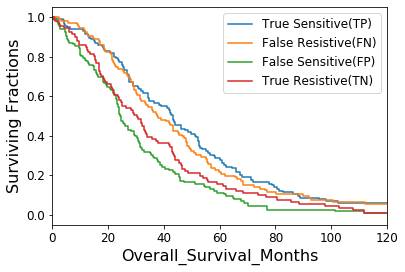

In [15]:
#Survival plot for RIBOCICLIB, EVEROLIMUS

create_drug_combo_survival_plot(genie_data, nest_pred_df, nest_pred_median_dict, [RIBOCICLIB, EVEROLIMUS])

Drug_Function
False Resistive(FN)    28.651316
False Sensitive(FP)    29.621711
True Resistive(TN)     35.773026
True Sensitive(TP)     41.430921
Name: Overall_Survival_Months, dtype: float64


                       N     Mean       SD      SE  95% Conf.  Interval
Drug_Function                                                          
False Resistive(FN)   60  34.4183  25.0162  3.2296    27.9559   40.8807
False Sensitive(FP)  148  39.2674  33.4012  2.7456    33.8416   44.6933
True Resistive(TN)   154  42.7027  35.9123  2.8939    36.9856   48.4199
True Sensitive(TP)    66  47.3928  40.4567  4.9799    37.4473   57.3383
                                                  sum_sq     df         F  \
C(CDK4_6_Inhibitor_Overall)                     1.956739    1.0  0.001644   
C(Ribociclib)                                 206.317322    1.0  0.173351   
C(CDK4_6_Inhibitor_Overall):C(Ribociclib)    5974.956905    1.0  5.020246   
Residual                                   504632.976713  424.0   

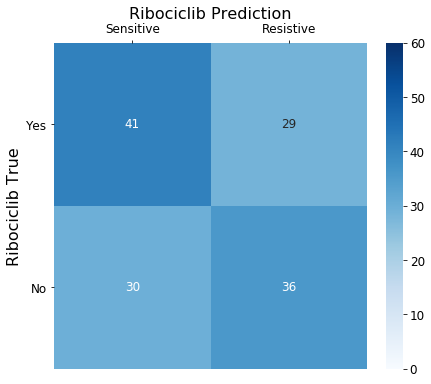

In [16]:
#Survival plot for RIBOCICLIB

tp, fn, fp, tn = create_drug_survival_plot(genie_drug_data, RIBOCICLIB)

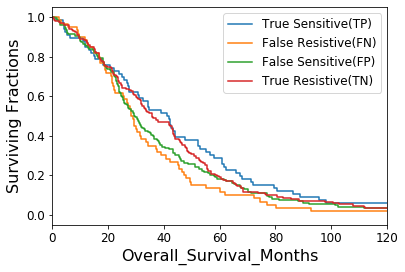

In [17]:
create_kaplan_meier(tp, fn, fp, tn, drug_name_map[RIBOCICLIB])

Drug_Function
False Resistive(FN)    28.256579
False Sensitive(FP)    29.835526
True Resistive(TN)     35.723684
True Sensitive(TP)     41.875000
Name: Overall_Survival_Months, dtype: float64


                       N     Mean       SD      SE  95% Conf.  Interval
Drug_Function                                                          
False Resistive(FN)   63  35.9821  29.7364  3.7464    28.4931   43.4712
False Sensitive(FP)  151  39.2317  33.2894  2.7091    33.8788   44.5845
True Resistive(TN)   151  42.8067  36.0573  2.9343    37.0088   48.6046
True Sensitive(TP)    63  46.4468  38.1695  4.8089    36.8340   56.0597
                                                   sum_sq     df         F  \
C(CDK4_6_Inhibitor_Overall)                      3.391163    1.0  0.002839   
C(Palbociclib)                                  33.332014    1.0  0.027908   
C(CDK4_6_Inhibitor_Overall):C(Palbociclib)    4381.208365    1.0  3.668312   
Residual                                    506399.710560  424

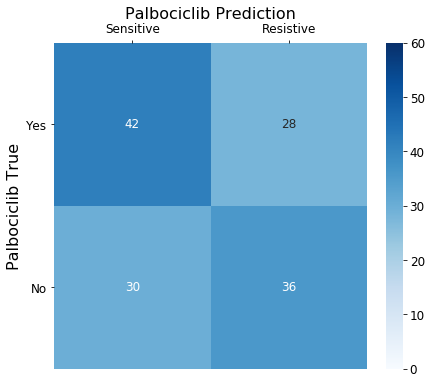

In [18]:
#Survival plot for PALBOCICLIB

tp, fn, fp, tn = create_drug_survival_plot(genie_drug_data, PALBOCICLIB)

In [19]:
create_gene_survival_plot(genie_drug_data, nest_pred_median_dict, all_mutation_data, 'CDK4', RIBOCICLIB)

Drug_Function
False Resistive(FN)    32.894737
False Sensitive(FP)    27.072368
True Resistive(TN)     36.430921
True Sensitive(TP)     31.546053
Name: Overall_Survival_Months, dtype: float64


                       N     Mean       SD       SE  95% Conf.  Interval
Drug_Function                                                           
False Resistive(FN)  210  40.4435  33.6658   2.3232    35.8636   45.0233
False Sensitive(FP)    3  36.9956  18.0489  10.4206    -7.8404   81.8317
True Resistive(TN)     4  37.0477   9.7584   4.8792    21.5200   52.5754
True Sensitive(TP)   211  41.8413  36.0344   2.4807    36.9510   46.7316


(0       20.723684
 1      161.118421
 2       88.815789
 3       56.611842
 5      181.743421
           ...    
 416     13.125000
 417     26.743421
 418     67.434211
 421      7.993421
 422     11.644737
 Name: Overall_Survival_Months, Length: 211, dtype: float64,
 4       62.236842
 9       55.296053
 12     129.144737
 13       2.434211
 17       8.223684
           ...    
 423     34.506579
 424      5.953947
 425     22.072368
 426     37.302632
 427     19.671053
 Name: Overall_Survival_Months, Length: 210, dtype: float64,
 187    27.072368
 221    26.085526
 353    57.828947
 Name: Overall_Survival_Months, dtype: float64,
 174    29.111842
 203    43.750000
 228    47.072368
 234    28.256579
 Name: Overall_Survival_Months, dtype: float64)

Drug_Function
False Resistive(FN)    48.092105
False Sensitive(FP)    26.496711
True Resistive(TN)     28.190789
True Sensitive(TP)     47.351974
Name: Overall_Survival_Months, dtype: float64


                       N     Mean       SD      SE  95% Conf.  Interval
Drug_Function                                                          
False Resistive(FN)   68  56.5359  45.2268  5.4846    45.5887   67.4831
False Sensitive(FP)  144  35.5672  33.9618  2.8302    29.9729   41.1615
True Resistive(TN)   146  34.0125  26.8486  2.2220    29.6208   38.4042
True Sensitive(TP)    70  52.1269  31.3597  3.7482    44.6494   59.6043
                                                sum_sq     df          F  \
C(mTOR_Inhibitor_Overall)                 35620.509748    1.0  31.838744   
C(Everolimus)                                14.485140    1.0   0.012947   
C(mTOR_Inhibitor_Overall):C(Everolimus)     831.269735    1.0   0.743015   
Residual                                 474362.179433  424.0        N

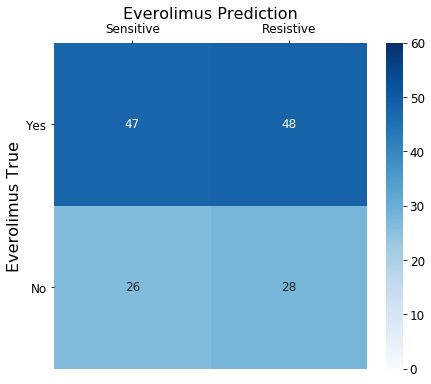

In [20]:
#Survival plot for EVEROLIMUS

tp, fn, fp, tn = create_drug_survival_plot(genie_drug_data, EVEROLIMUS)

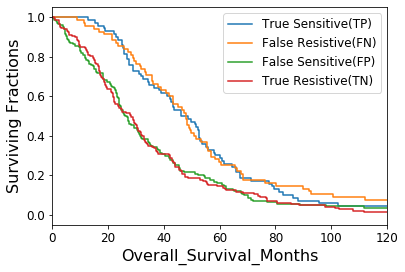

In [21]:
create_kaplan_meier(tp, fn, fp, tn, drug_name_map[EVEROLIMUS])

In [22]:
#create_gene_survival_plot(genie_drug_data, nest_pred_median_dict, all_mutation_data, 'MTOR', EVEROLIMUS)

In [23]:
#create_gene_survival_plot(genie_drug_data, nest_pred_median_dict, all_mutation_data, 'PIK3CA', EVEROLIMUS)

In [24]:
#Survival plot for CAPIVASERTIB

#create_drug_survival_plot(genie_drug_data, CAPIVASERTIB)

In [25]:
#create_gene_survival_plot(genie_drug_data, nest_pred_median_dict, all_mutation_data, 'AKT1', CAPIVASERTIB)

In [26]:
#For DrugCell_Classic

#drugcell_genes = pd.read_csv('../../drugcell/data/gene2ind.txt', sep='\t', header=None, names=['I', 'G'])['G']

#filtered_mut_data = generate_cell_mutation_file(list(all_genie_genes), list(drugcell_genes), genie_data, all_mutation_data)

#filtered_mut_data.to_csv('../../drugcell/data/GENIE_all_cell2mutation.txt', header=False, index=False)
#cell_lines.to_csv('../../drugcell/data/GENIE_all_cell2ind.txt', sep='\t', header=False, index=True)
#test_data.to_csv("../../drugcell/data/GENIE_all_test.txt", sep='\t', header=False, index=False)

In [27]:
dc_predict_data = np.loadtxt('../../drugcell/result/predict_genie_all_drugcell.txt')

dc_pred_df = pd.Series(dc_predict_data, name='P_AUC')
dc_pred_df = pd.concat([test_data, dc_pred_df], axis=1)[['C', 'D', 'P_AUC']]
    
dc_pred_median_dict = dc_pred_df.groupby('D')['P_AUC'].median().to_dict()
for key in dc_pred_median_dict.keys():
    print(drug_name_map[key], ':', dc_pred_median_dict[key])

Capivasertib : 0.69895
Palbociclib : 0.716205
Ribociclib : 0.71037
Everolimus : 0.6401650000000001
Fulvestrant : 0.92076


In [28]:
dc_genie_drug_data = genie_data.copy()
for d in drug_name_map.keys():
    dc_genie_drug_data[drug_name_map[d]] = ""

for i,row in genie_data.iterrows():
    sampleId = row['Sample_ID']
    df = dc_pred_df.query('C == @sampleId')
    for d in drug_name_map.keys():
        p_auc = df[df.D == d]['P_AUC'].item()
        if p_auc <= dc_pred_median_dict[d]:
            dc_genie_drug_data.at[i, drug_name_map[d]] = "Sensitive"
        else:
            dc_genie_drug_data.at[i, drug_name_map[d]] = "Resistive"


True Sensitive: 121
False Resistive: 100
False Sensitive: 107
True Resistive: 100
True Sensitive median: 36.41447368
False Resistive median: 45.55921053
False Sensitive median: 27.26973684
True Resistive median: 24.50657895


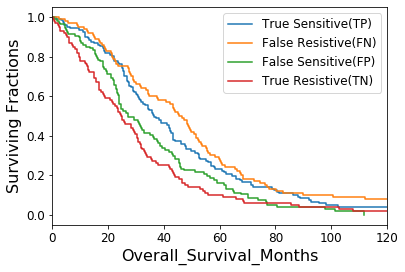

In [29]:
#Survival plot for RIBOCICLIB, EVEROLIMUS

create_drug_combo_survival_plot(genie_data, dc_pred_df, dc_pred_median_dict, [RIBOCICLIB, EVEROLIMUS])

Drug_Function
False Resistive(FN)    32.697368
False Sensitive(FP)    32.796053
True Resistive(TN)     31.858553
True Sensitive(TP)     31.348684
Name: Overall_Survival_Months, dtype: float64


                       N     Mean       SD      SE  95% Conf.  Interval
Drug_Function                                                          
False Resistive(FN)   54  39.2727  30.2536  4.1170    31.0150   47.5303
False Sensitive(FP)  142  40.2226  28.4375  2.3864    35.5048   44.9404
True Resistive(TN)   160  41.7262  39.4950  3.1224    35.5595   47.8928
True Sensitive(TP)    72  42.6709  37.4797  4.4170    33.8636   51.4782
                                                  sum_sq     df         F  \
C(CDK4_6_Inhibitor_Overall)                     3.638953    1.0  0.003024   
C(Ribociclib)                                   0.642250    1.0  0.000534   
C(CDK4_6_Inhibitor_Overall):C(Ribociclib)     525.760409    1.0  0.436856   
Residual                                   510287.848281  424.0   

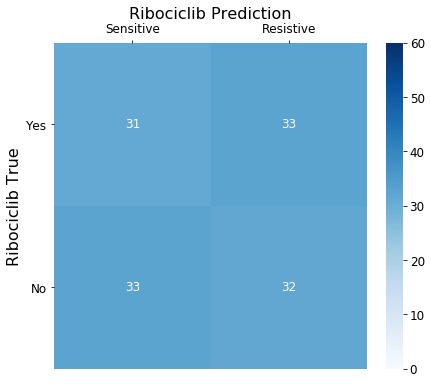

In [30]:
#Survival plot for RIBOCICLIB

tp, fn, fp, tn = create_drug_survival_plot(dc_genie_drug_data, RIBOCICLIB)

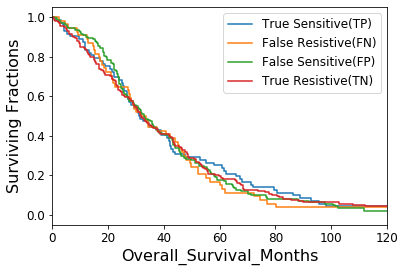

In [31]:
create_kaplan_meier(tp, fn, fp, tn, drug_name_map[RIBOCICLIB])

Drug_Function
False Resistive(FN)    50.657895
False Sensitive(FP)    27.500000
True Resistive(TN)     25.032895
True Sensitive(TP)     42.269737
Name: Overall_Survival_Months, dtype: float64


                       N     Mean       SD      SE  95% Conf.  Interval
Drug_Function                                                          
False Resistive(FN)   69  60.8352  46.2935  5.5731    49.7143   71.9562
False Sensitive(FP)  145  36.9099  30.5859  2.5400    31.8894   41.9305
True Resistive(TN)   145  32.6590  30.4609  2.5296    27.6590   37.6591
True Sensitive(TP)    69  47.7636  28.1665  3.3909    40.9973   54.5300
                                                sum_sq     df          F  \
C(mTOR_Inhibitor_Overall)                 35609.707794    1.0  32.261584   
C(Everolimus)                               190.523511    1.0   0.172610   
C(mTOR_Inhibitor_Overall):C(Everolimus)    7014.474164    1.0   6.354954   
Residual                                 468002.936633  424.0        N

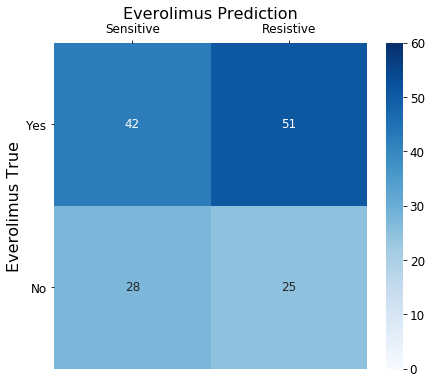

In [32]:
#Survival plot for EVEROLIMUS

tp, fn, fp, tn = create_drug_survival_plot(dc_genie_drug_data, EVEROLIMUS)

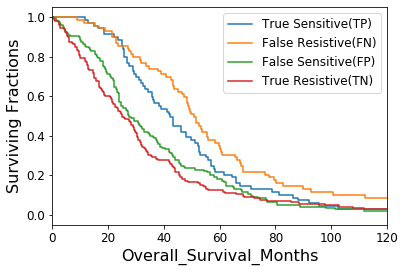

In [33]:
create_kaplan_meier(tp, fn, fp, tn, drug_name_map[EVEROLIMUS])

In [34]:
#create_gene_survival_plot(genie_drug_data, dc_pred_median_dict, all_mutation_data, 'CDK4', RIBOCICLIB)

In [35]:
#create_gene_survival_plot(genie_drug_data, dc_pred_median_dict, all_mutation_data, 'MTOR', EVEROLIMUS)

In [36]:
#Survival plot for CAPIVASERTIB

#create_drug_survival_plot(dc_genie_drug_data, CAPIVASERTIB)

In [37]:
#create_gene_survival_plot(genie_drug_data, dc_pred_median_dict, all_mutation_data, 'AKT1', CAPIVASERTIB)

In [38]:
print(genie_data.groupby(by=['Primary_Race']).median()['Overall_Survival_Months'])

print(rp.summary_cont(genie_data['Overall_Survival_Months'].groupby(genie_data['Primary_Race'])))

Primary_Race
Black    29.967105
Other    29.490132
White    32.532895
Name: Overall_Survival_Months, dtype: float64


                N     Mean       SD      SE  95% Conf.  Interval
Primary_Race                                                    
Black          26  34.0081  19.9524  3.9130    25.9491   42.0671
Other          36  36.2281  24.2568  4.0428    28.0207   44.4354
White         328  41.8979  37.1091  2.0490    37.8670   45.9288
